In [1]:
import os
import numpy as np
from matplotlib.pyplot import *
import h5py
import datetime
import pytz

from dronepkg import corr
from dronepkg import concat
from dronepkg import drone
from dronepkg import bicolog
import dronepkg.plotting_utils as pu
import dronepkg.fitting_utils as fu
import dronepkg.geometry_utils as gu
import dronepkg.time_utils as tu

from dronepkg.sites import site
gbosite=site.site('../dronepkg/dronepkg/sites/GBO_config.npz')

In [2]:
## Read Drone Data: 
dronedir='/hirax/all_drone_data/datcon_csv/'
dronetest=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY653.csv',site_class=gbosite)

Initializing drone data via datcon_csv routine: FLY653.csv
 --> Skipping rows 1 to 499 to eliminate NAN values
 --> Attempting to load position data from RTK
 ----> RTK Data not found for this data file...
 --> Loading position data from GPS(0) instead:
Timestamp interpolation succeeded
 --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
 --> generating dish and receiver line of sight coordinates.


In [ ]:
## Attempt to initialize correlator data class from new format: [working!]
gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/20211022T215446Z_yale_drone_yale_digitalgain/'
datadir='/hirax/GBO_Oct_2021/TONE_ACQ/20211022T215446Z_yale_drone/corr/20211022T215459Z/'
corrtest=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,site_class=gbosite)

Initializing Correlator Class using:
 --> /hirax/GBO_Oct_2021/TONE_ACQ/20211022T215446Z_yale_drone/corr/20211022T215459Z/
 --> Arrays initialized with shape (108, 256, 1023, 16)
Assigning array values by reading in data files:
 --> Loading File: 0065/0107

In [ ]:
#pulsedgrid200m_drone.Plot_Drone_Coordinates()
plot(dronetest.t_arr_datetime)
plot(corrtest.t_arr_datetime)

In [ ]:
## Test plotting functions: [They are working!]
#pu.Plot_Waterfalls(main_beam_corr)
#pu.Plot_Time_Series(main_beam_corr,tbounds=[100,1000],freqlist=[850,900])

In [ ]:
concattest=concat.CONCAT(CORRDATCLASS=corrtest,DRONEDATCLASS=dronetest)

In [ ]:
tlb,tub=[14200,14700]
find=900

fig=figure(figsize=(16,8))
for i in range(concattest.n_channels)[:2]:
    ax1=fig.add_subplot(2,2,i+1)
    ax2=fig.add_subplot(2,2,i+3)
    ax1.semilogy(concattest.t_index[:],concattest.V[:,find,concattest.chmap[i]],'.')
    for ax in [ax1,ax2]:
        ax.semilogy(concattest.t_index[tlb:tub],concattest.V[tlb:tub,find,concattest.chmap[i]],'.')


In [ ]:
concattest.Extract_Source_Pulses(Period=0.4e6,Dutycycle=0.2e6,t_bounds=[14200,14700])
concattest.Perform_Background_Subtraction()

In [ ]:
semilogy(concattest.V[:,find,0],'.')
semilogy(concattest.V_bg[:,find,0],'.')
plot(concattest.drone_xyz_LC_interp)

In [ ]:
concattest.Plot_Beammap_LC(t_bounds=[0,25000],coord_args="Pol",pulse_args="on",f_bounds=[300,340],dotsize=40)

2021-10-22 13:08:33.781205+00:00
[datetime.timedelta(microseconds=41943)
 datetime.timedelta(microseconds=41943)
 datetime.timedelta(microseconds=41943)
 datetime.timedelta(microseconds=41943)
 datetime.timedelta(microseconds=41943)
 datetime.timedelta(microseconds=41943)
 datetime.timedelta(microseconds=41943)
 datetime.timedelta(microseconds=41943)
 datetime.timedelta(microseconds=41943)
 datetime.timedelta(microseconds=41943)]


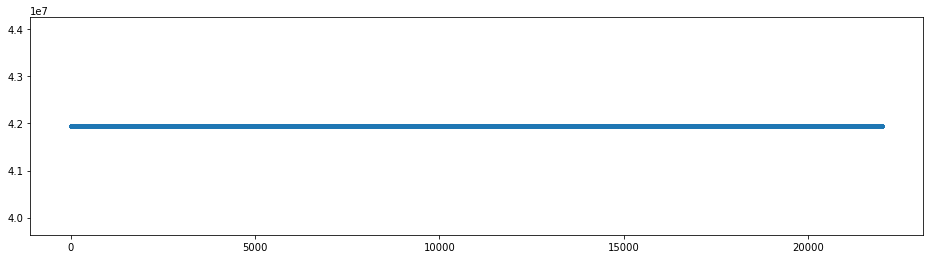

In [6]:
## Bugfix 1: datetimes from irigb_time in the corr.py class: [now successfully integrated into corr class]
## Datetime debugging: using 'irigb_time' works, but need to divide by 1e9 
datadir='/hirax/GBO_Oct_2021/TONE_ACQ/20211022T125439Z_yale_drone/corr/20211022T125451Z/'
fd=h5py.File(datadir+'0077','r')
tib=fd['index_map']['time']['irigb_time']
tdt=[datetime.datetime.fromtimestamp(1e-9*k,pytz.timezone('America/Montreal')).astimezone(pytz.utc) for k in tib]
print((tdt)[0])
print(np.diff(tdt)[:10])
## Plot fixed timestamps:
fig=figure(figsize=(16,4))
plot(np.diff(main_beam_corr.t),'.',)